In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image as im, ImageFont, ImageDraw
import cv2 as cv
from pprint import pprint 
import os
from tqdm import tqdm
import copy
import time

import warnings
warnings.filterwarnings("ignore")

In [5]:
def trimWhiteSpace(img):
    for j in range(img.shape[1]-2):
        if((img[:,j+1:] == np.ones(img[:,j+1:].shape)*255).all()):
            img = img[:,:j+1]
    for i in range(img.shape[0]-2):
        if((img[i+1:,:] == np.ones(img[i+1:,:].shape)*255).all()):
            img = img[:i+1,:]
    
    for i in range(img.shape[0]-1,1,-1):
        if((img[i::-1,:] == np.ones(img[i::-1,:].shape)*255).all()):
            img = img[i:,:]
    return img

In [6]:
# generate images from text, word by word using PILlow
def generateImages(w,basePath,fontPath):
    
    imgs = []
    sizes = []
    for s in range(8,40):                            
        with im.open(basePath).convert("RGBA") as base:
            txtt = im.new("RGBA", base.size, (255,255,255,255))   #base.size = ((len(w)*15)+(len(w)*5),50)
            fnt = ImageFont.truetype(fontPath,s)
            d = ImageDraw.Draw(txtt)
            d.text((0,30),w,font=fnt,fill=(0,0,0,255))
            txtt.save(w+".png","PNG")
            
            imm = cv.imread(w+".png")
            imm = trimWhiteSpace(imm)
            imgs.append(imm)
            sizes.append(s)
            os.remove(w+".png")
    
    return (imgs,sizes)

In [8]:
s = time.time()
ims = generateImages("segmentation","./imgs/im13.png","./Fonts/arial.ttf")
fn = time.time()

30.429168462753296

In [48]:
def erreurQuad(test,orig):
    
    l,c = (orig.shape[0],orig.shape[1])
    N = (1/(l*c))
    return N * np.sum((orig-test)**2)


In [ ]:
def findText3(im1,im2):
    res = cv.matchTemplate(im1,im2,cv.TM_SQDIFF)
    minV,maxV,minPos,maxPos = cv.minMaxLoc(res)
    w,h = (im2.shape[0],im2.shape[1])
    top_left = minPos    
    bottom_right = (top_left[0]+h,top_left[1]+w)
    #cv.rectangle(im1,top_left,bottom_right,255,0)
    
    psnr=cv.PSNR(im1[top_left[1]:top_left[1]+w,top_left[0]:top_left[0]+h],im2)
    sqdif=erreurQuad(im1[top_left[1]:top_left[1]+w,top_left[0]:top_left[0]+h],im2)
    
    if(psnr>10 or sqdif<144):
        #plt.imshow(im1[top_left[1]:top_left[1]+w,top_left[0]:top_left[0]+h])
        return True

In [ ]:
def findTextV3(doc,wordImages):
    
    for i in range(len(wordImages)):
        if(findText3(doc,wordImages[i])):
            return (True,i)

    return (False,None)                

In [ ]:
def bruteForceSearch(docPath,text,fontsPath):
    
    doc = cv.imread(docPath)
    
    words = text.split(" ")
    founds = [False]*len(words)
    
    
    
    # get list of fonts files names
    fonts = []
    
    #go to fonts dir    
    os.chdir(fontsPath)
    for elm in os.listdir():
        fonts.append(elm)
    
    # return to principal dir
    os.chdir("..")
    
    #for each word, for each font generate images and test
    
    
    # on commence par le premier mot, si on le trouve alors tester les autres juste avec le font
    # de ce dernier, sinon arrêter car si un seul mot n'existe pas alors la phrase ou
    # le paragraphe n'existe pas
    
    winnerFont = ""
    winnerSize = -1
    
    for f in fonts:
        (images,sizes) = generateImages(words[0],docPath,fontsPath+"/"+f)    
        (res,size) = findTextV3(doc,images)
        if(res):
            winnerFont = f
            winnerSize = size
            founds[0] = True
            break
    
    for i in range(1,len(words)):
        images = generateImages(words[i],docPath,fontsPath+"/"+winnerFont)    
        
        #try directly winner size
        
        if(findText3(doc,images[winnerSize])):
            founds[i] = True
            continue
        
        # if not found, test other sizes
        
        if(findTextV3(doc,images)):
            founds[i] = True
        else:
            founds[i] = False
    
        
            
    
    
    return founds
        
            
    

In [116]:
a = cv.imread("./imgs/im6P.png")
b = cv.imread("./imgs/im6P2.png")
a = trimWhiteSpace(a)
b = trimWhiteSpace(b)
a = a[:b.shape[0],:b.shape[1],:]

In [111]:
def compareImgs(a,b):
    a = cv.cvtColor(a,cv.COLOR_RGB2GRAY)
    b = cv.cvtColor(b,cv.COLOR_RGB2GRAY)
    
    a=a.astype('double')
    b=b.astype('double')
    
    res = a-b
    
    ones = copy.deepcopy(res)

    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            if(res[i,j]==0 or np.abs(res[i,j])<50):
                ones[i,j] = 1
            else:
                ones[i,j] = 0
    
    t = ones[ones==1] 
    
    if(len(t)>(res.shape[0]*res.shape[1])/2):
        return True
    
    return False


In [113]:
r = compareImgs(a,a)
r

True

In [117]:
cv.PSNR(a,b)

7.400703671494339

In [118]:
erreurQuad(a,b)

215.55840754321636

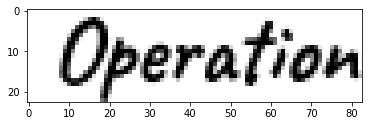

In [120]:
plt.imshow(b)

In [103]:
a = np.array([np.array(np.array([1,1,1])),np.array([1,2,3]),np.array([1,1,3])])

In [107]:
a[a==2]

array([2])